### Translated R to Python from https://github.com/alanjeffares/elements-of-statistical-learning/tree/master/chapter-4

In [67]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets

In [60]:
# Main logic for fitting LDA using discriminant function (eqn 4.10)
def LDA(data, target):
    LDA_params = namedtuple("LDA_params", ["pi_k", "mu_k", "sigma"])
    data.drop_duplicates()
    classes = data[target].unique().tolist()
    K = len(classes)
    N = len(data)
    # print("N: {}".format(N))
    pi_list = [] # store k pi_k's
    mu_list = [] # store k mu_k's
    sigma_list = [] # store k cov matrices to sum

    # loop through classes to get parameter estimates by class
    # example pi_k, mu_k and sigma_k
    i = 0
    for classe in classes:
        i = i + 1
        # print("classe: {}".format(classe))
        subset_df = data.where(data[target] == classe)
        subset_df = subset_df[subset_df[target].notnull()]
        N_k = len(subset_df)
        # print("N_k ({}): {}".format(i, N_k))
        pi_k = N_k/N
        X_subset = subset_df.drop(target, axis=1).to_numpy()
        # print(X_subset.shape)
        mu_k = X_subset.sum(axis=0)/N_k # p x 1 
        # print(mu_k.shape)
        X_subset_center = X_subset - mu_k
        # print(X_subset_center.shape)
        sigma_k = np.cov(X_subset_center, rowvar=False)*(N_k-1) # N_k-1 as cov function has this on the denominator
        # print(sigma_k)
        # print(sigma_k.shape)
        pi_list.append(pi_k)
        mu_list.append(mu_k)
        sigma_list.append(sigma_k)
    sigma = sum(sigma_list)/(N-K)
    return LDA_params(pi_list, mu_list, sigma)

In [26]:
def predict_discriminants(x, pi_list, mu_list, sigma):
    K=len(pi_list)
    scores = []
    for i in range(K):
        sigma_inv = np.linalg.inv(sigma)
        a = np.array(x).dot(sigma_inv).dot(mu_list[i])
        b = 0.5 * np.transpose(mu_list[i]).dot(sigma_inv).dot(mu_list[i])
        score = a - b + np.log(pi_list[i])
        scores.append(score)
    return scores

In [23]:
# predict label for a single observation
def predict_label(x, pi_list, mu_list, sigma):
    preds = predict_discriminants(x, pi_list, mu_list, sigma)
    return np.argmax(preds)

In [24]:
# predict for a full data.frame of observations
def predict_labels(X, pi_list, mu_list, sigma):
    predictions = []
    for i in range(len(X)):
        x = X[i]
        label_i = predict_label(x, pi_list, mu_list, sigma)
        predictions.append(label_i)
    return predictions

In [37]:
# now lets test out the fuction on a subset of the iris dataset
iris = datasets.load_iris()
data = pd.DataFrame(iris.data, columns = iris.feature_names)
data['Species'] = iris.target

data_flat = data[['sepal length (cm)', 'sepal width (cm)', 'Species']]
data_flat.head()

,sepal length (cm),sepal width (cm),Species
0,5.1,3.5,0
1,4.9,3.0,0
2,4.7,3.2,0
3,4.6,3.1,0
4,5.0,3.6,0


In [61]:
# first fit to the data 
fit = LDA(data_flat, target = 'Species')

In [63]:
fit

LDA_params(pi_k=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333], mu_k=[array([5.006, 3.428]), array([5.936, 2.77 ]), array([6.588, 2.974])], sigma=array([[0.26500816, 0.09272109],
       [0.09272109, 0.11538776]]))

In [114]:
# make a grid of values to predict on (so we can see the rough boundries)
delta = 0.05
x_vals = np.linspace(start=np.min(data_flat["sepal length (cm)"].to_numpy())-delta, stop=np.max(data_flat["sepal length (cm)"].to_numpy())+delta, num=200)
y_vals = np.linspace(start=np.min(data_flat["sepal width (cm)"].to_numpy())-delta, stop=np.max(data_flat["sepal width (cm)"].to_numpy())+delta, num=200)
grid = np.array([[x, y] for x in x_vals for y in y_vals])

In [112]:
# predict the label of each point on the grid
preds = predict_labels(grid, fit.pi_k, fit.mu_k, fit.sigma)

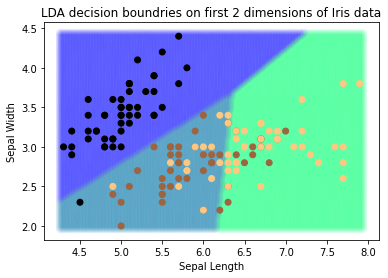

In [143]:
# visualise the results
plt.title('LDA decision boundries on first 2 dimensions of Iris data')
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.scatter(x=grid[:, 0], y=grid[:, 1], c=preds, alpha = 0.027, cmap="winter")
plt.scatter(data_flat["sepal length (cm)"], data_flat["sepal width (cm)"],c=data_flat["Species"],  marker = "o", alpha=1, cmap='copper')

In [ ]:
# optionally include contour plots
# nlevels <- c(3, 3, 2)
# x.points <- seq(4,8,length.out=100)
# y.points <- seq(1,5,length.out=100)
# sigma <- fit$sigma
# for (k in 1:length(fit$mu_k)){
#   z <- matrix(0,nrow=100,ncol=100)
#   mu <- fit$mu_k[[k]]
#   for (i in 1:100) {
#     for (j in 1:100) {
#       z[i,j] <- dmvnorm(c(x.points[i],y.points[j]),
#                         mean=mu,sigma=sigma)
#     }
#   }
#   contour(x.points, y.points, z, add = TRUE, nlevels = 3)
# }

# palette(c("blue","seagreen4","orangered3"))
# points(data_flat$Sepal.Length, data_flat$Sepal.Width, col=data_flat$Species, pch=16, cex=1.25)



In [ ]:
# testing performance on vowel data (https://web.stanford.edu/~hastie/ElemStatLearn/)
# test <- read.csv('vowel_test.csv')
# train <- read.csv('vowel_train.csv')

# v_fit <- LDA(train[,2:12], target = 'y')

In [ ]:
# confirm that these predictions match those in table 4.1 (p 107)
# train_preds <- predict_labels(train[,3:12], v_fit$pi_k, v_fit$mu_k, v_fit$sigma)
# train_accuracy <- sum(train_preds == train$y)/nrow(train)
# train_error <- 1 - train_accuracy
# print(paste0('Train error: ', train_error))

# test_preds <- predict_labels(test[,3:12], v_fit$pi_k, v_fit$mu_k, v_fit$sigma)
# test_accuracy <- sum(test_preds == test$y)/nrow(test)
# test_error <- 1 - test_accuracy
# print(paste0('Test error: ', test_error))

# and they match!